In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from itertools import combinations
import anndata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

import plotting_functions as pf

In [2]:
plate_palette = sns.color_palette("husl", n_colors=3)
sex_palette = ['hotpink','dodgerblue']
geno_palette = ['#DA9CC1', '#F4C245', '#C0BFBF', '#55AF5B', '#4F6EAF', '#52A5DB', '#D83026', '#683C91']


# QC plotting - 200 UMI merged adata

In [2]:
adata = sc.read("../IGVF_analysis/preprocessed_tissues/Heartpreprocessed.h5ad")


In [3]:
adata.layers['raw_counts'] = adata.X.copy()


In [4]:
adata

AnnData object with n_obs × n_vars = 1624987 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'doublet_scores', 'batch'
    var: 'gene_name'
    layers: 'raw_counts'

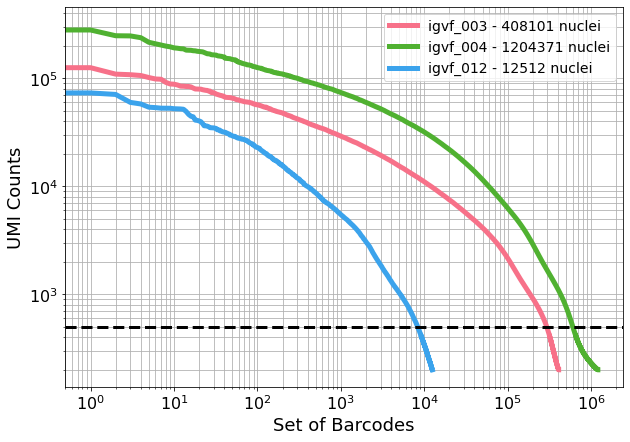

In [5]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

In [6]:
# set var names to be gene names, not gene ID
adata.var_names  = adata.var['gene_name']
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


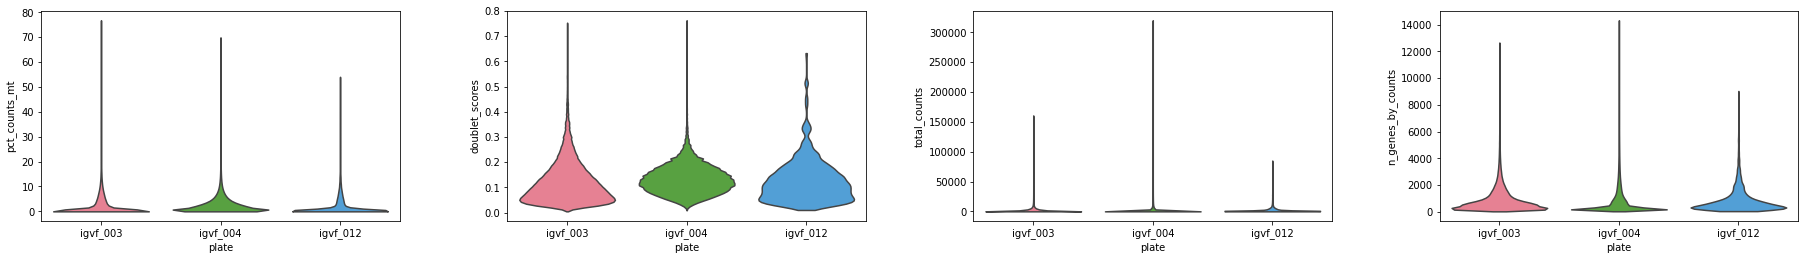

In [7]:
plate_palette = sns.color_palette("husl", n_colors=3)

sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

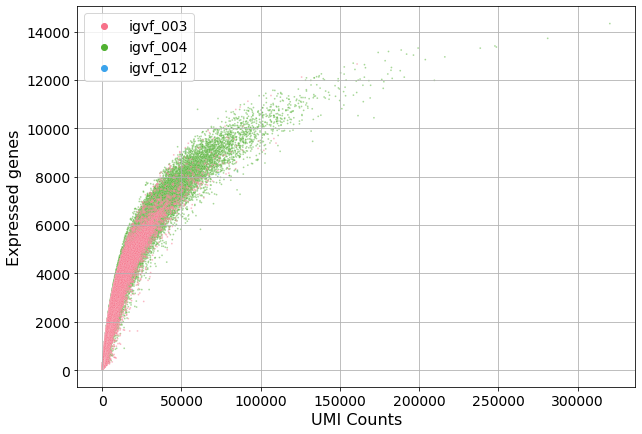

In [8]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

In [9]:
adatas = adata[(adata.obs['total_counts'] < 10000) & (adata.obs['n_genes_by_counts'] < 2000), :]


/opt/apps/python/3.8.0/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


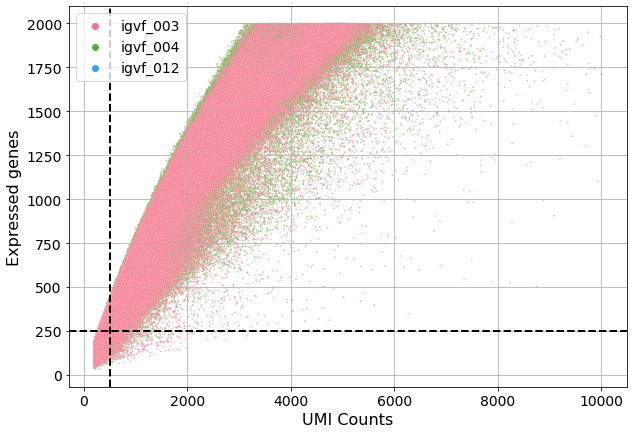

In [11]:
pf.plot_genes_by_counts(adatas, category_column='plate', figsize=(10, 7))

plt.axvline(x=500, color='k', linestyle='--', linewidth=2)
plt.axhline(y=250, color='k', linestyle='--', linewidth=2)

plt.show()

In [12]:
adatas[(adatas.obs['total_counts'] > 500) & (adatas.obs['n_genes_by_counts'] < 250), :]


View of AnnData object with n_obs × n_vars = 4158 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw_counts'

# QC plotting - filtered data
500 UMI, 250 genes, 1% mito, 0.25 doublet score


In [13]:
adata = sc.read("../IGVF_analysis/tissue_processed_500umi/Heart_processed.h5ad")


In [14]:
adata.layers

Layers with keys: raw_counts

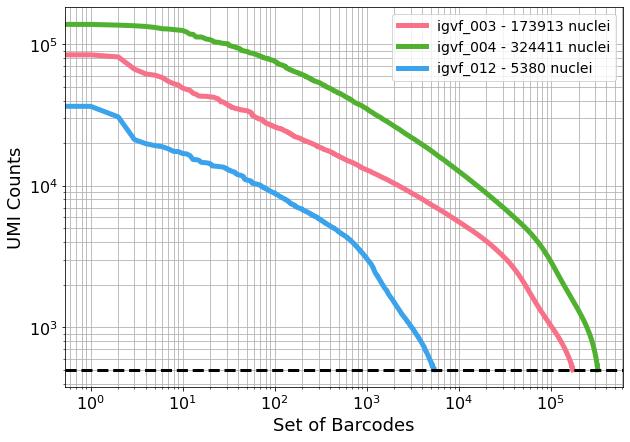

In [15]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

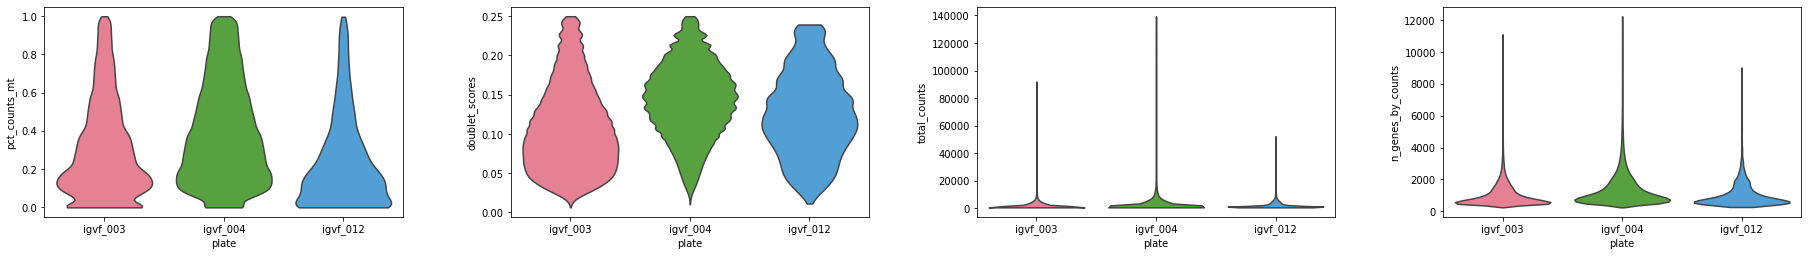

In [16]:
sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

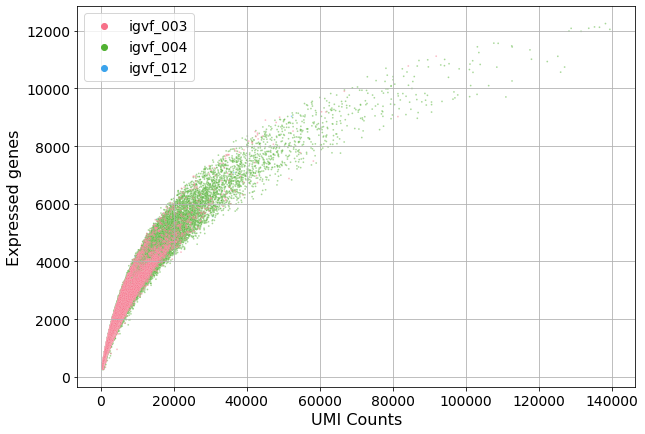

In [17]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

In [18]:
print(adata.obs['Genotype'].value_counts())

adata = adata[adata.obs['Genotype'] != "tie",:]

print(adata.obs['Genotype'].value_counts())

Genotype
NZOJ      84060
129S1J    75037
PWKJ      72820
CASTJ     65301
B6J       61956
NODJ      51796
AJ        46583
WSBJ      46112
tie          42
Name: count, dtype: int64
Genotype
NZOJ      84060
129S1J    75037
PWKJ      72820
CASTJ     65301
B6J       61956
NODJ      51796
AJ        46583
WSBJ      46112
Name: count, dtype: int64


# Check clustering
Plate, sex, genotype

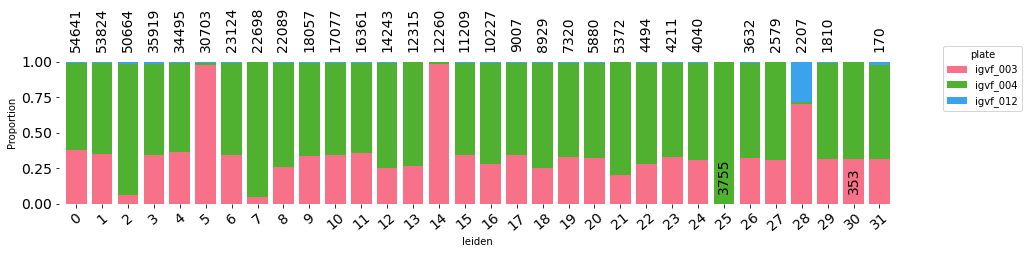

In [19]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'plate',
                            flip=False, fsize = (15,3), 
                            annotations = True)


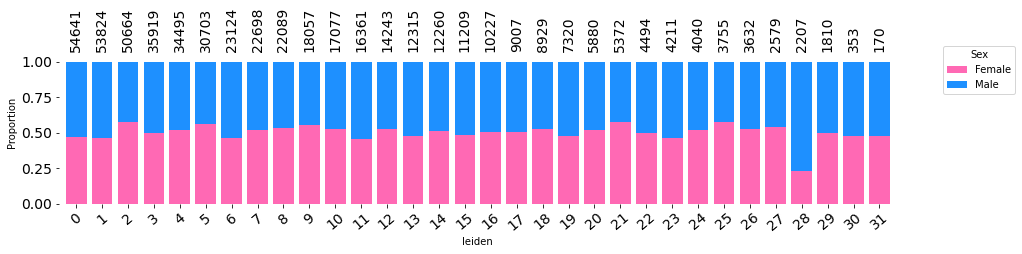

In [20]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Sex',
                            flip=False, fsize = (15,3), 
                            annotations = True)


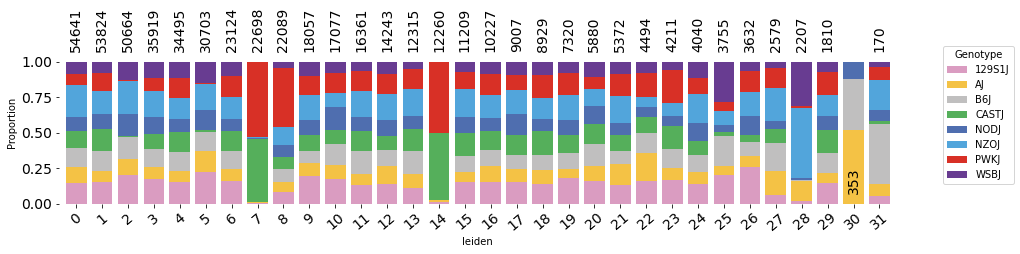

In [21]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Genotype',
                            flip=False, fsize = (15,3), 
                            annotations = True)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


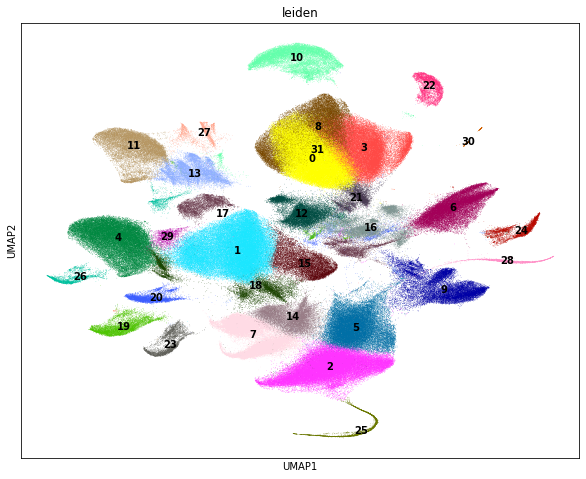

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


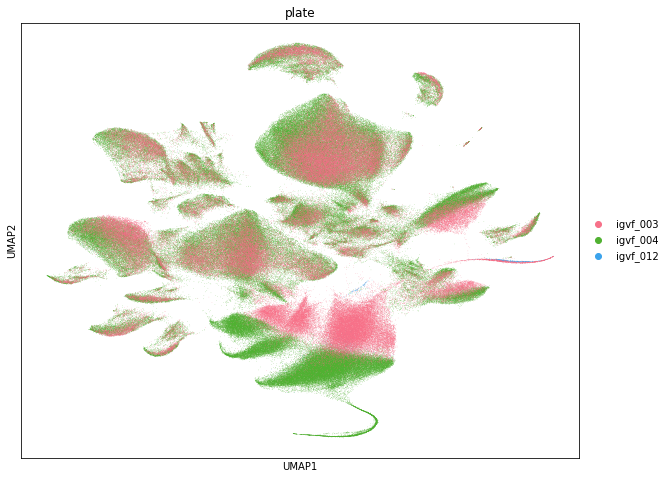

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


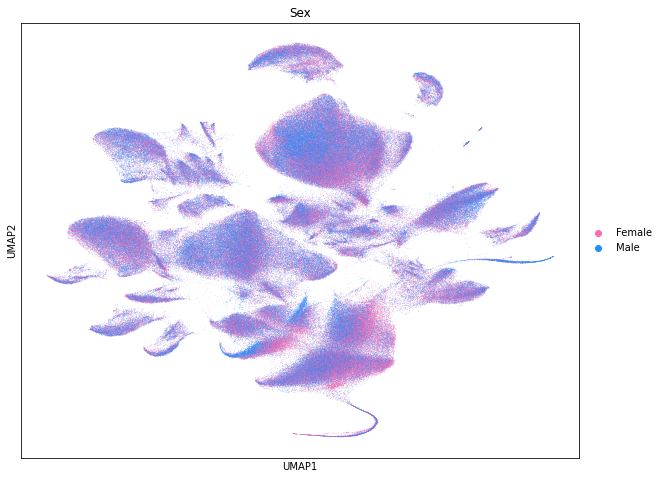

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


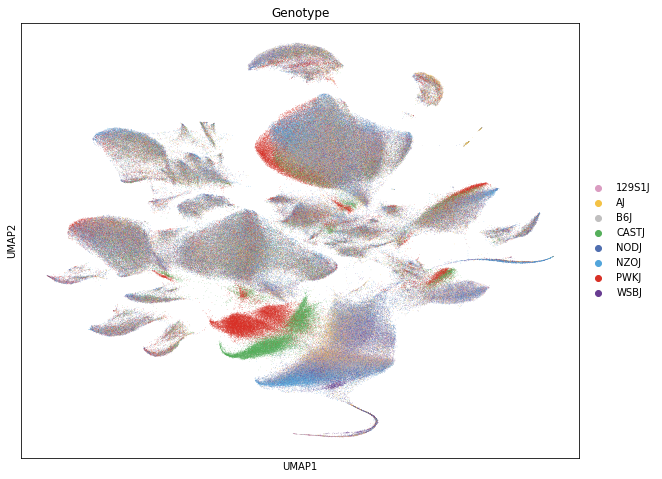

In [24]:
plt.rcParams['figure.figsize'] = (10, 8)

sc.pl.umap(adata, color=['leiden'], size=1, legend_loc = 'on data')

sc.pl.umap(adata, color=['plate'], size = 0.8, palette = plate_palette)

sc.pl.umap(adata, color=['Sex'], size = 0.8, palette = sex_palette)

sc.pl.umap(adata, color=['Genotype'], size = 0.8, palette = geno_palette)



# Check marker gene expression

In [9]:
marker_genes_dict = {
    "Adipocyte": ["Adipoq","Pnpla2"],
    "Endothelial": ["Flt1","Pecam1","Tie1","Kdr","Tek","Eng","Emcn"],
    "Lymphatic_endothelial": ["Prox1","Lyve1","Flt4"],
    "Endocardial": ["Nrg2","Sox17"],
    "Fibroblast": ["Mgp","Dcn","Col1a1","Pdgfra","Ddr2"],
    "Macrophage": ["Mrc1","Adgre1","Itgam","Fcgr1","Cx3cr1","F13a1"],
    "Lymphocyte": ["Ms4a1","Ikzf1","Ikzf3","Bcl11a","Themis","Il7r"],
    "Smooth_muscle1": ["Myh11","Mylk"],
    "Smooth_muscle2": ["Acta2","Tagln","Eln","Myl6","Myl9"],
    "Pericyte": ["Pdgfrb","P2ry14","Abcc9"],
    "Schwann": ["Cadm2","Sox10","Postn","Plp1"],
    "Epicardial": ["Abi1","Wt1","Aldh1a2"],
    "Cardiomyocyte_atrial": ['Myl7','Myl4','Nppa'],
    "Cardiomyocyte": ["Ryr2","Ttn","Actc1","Tnnt2","Tnnc1","Mybpc3","Myh6","Myh7","Atp2a2","Gata4","Mef2a","Mef2d"],
    "Cycling": ["Top2a","Mki67"],
    "Neuron": ["Snap25","Slc17a7"],
    "Liver": ["Alb", "Cyp1a2"],

}



In [27]:
adata.var_names  = adata.var['gene_name']


categories: 0, 1, 2, etc.
var_group_labels: Adipocyte, Endothelial, Lymphatic_endothelial, etc.


/Users/liz/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


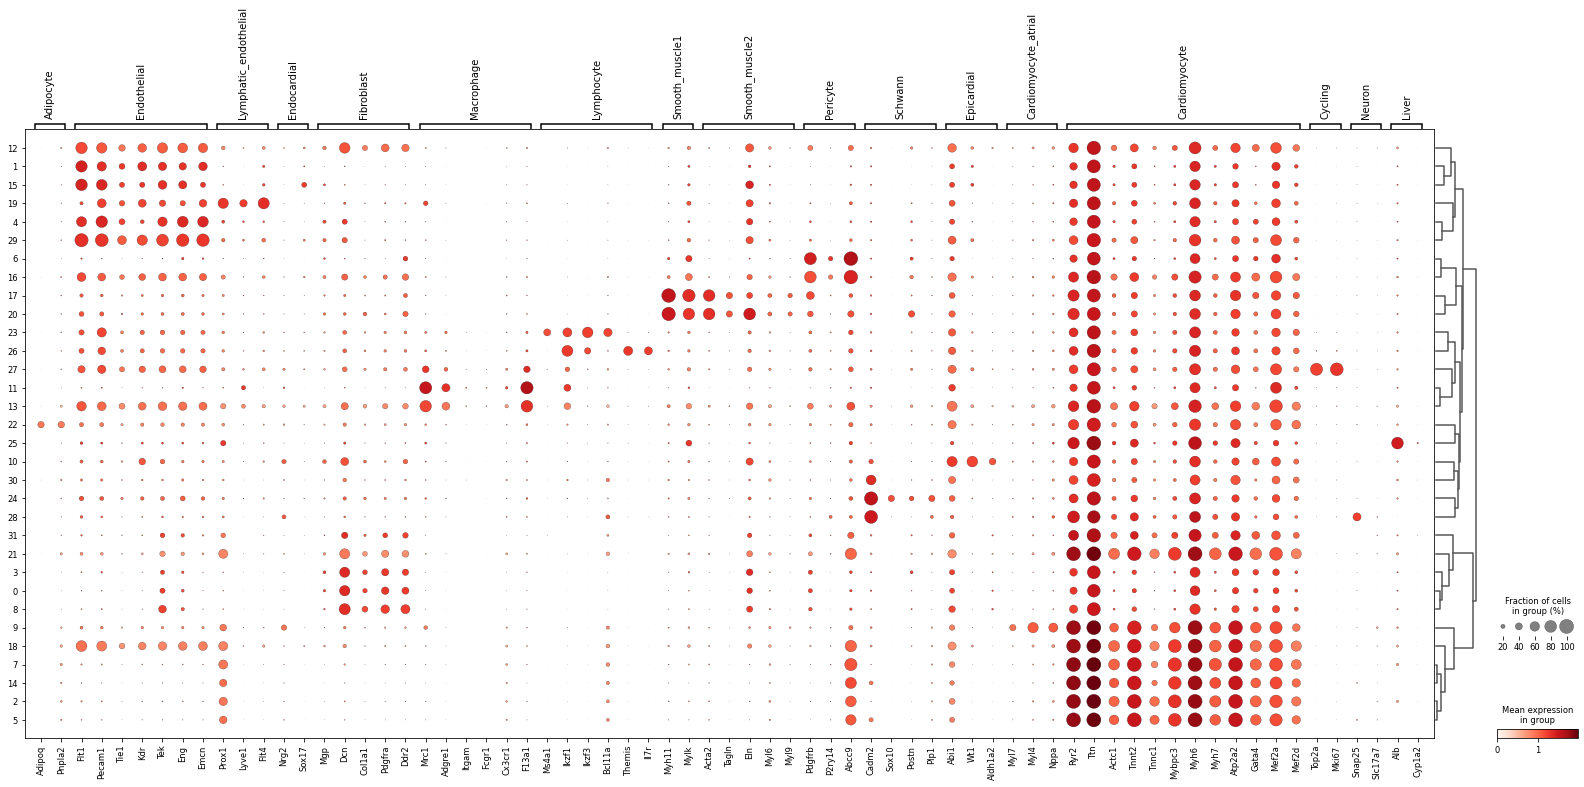

In [10]:
sc.pl.dotplot(adata, marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


In [11]:
smol_marker_genes_dict = {
    "Adipocyte": ["Adipoq"],
    "Endothelial": ["Flt1","Pecam1"],
    "Lymphatic_endothelial": ["Prox1"],
    "Endocardial": ["Sox17"],
    "Fibroblast": ["Dcn","Pdgfra"],
    "Macrophage": ["F13a1"],
    "B_cell": ["Bcl11a"],
    "T_cell": ["Themis"],
    "Smooth_muscle1": ["Myh11","Mylk"],
    "Smooth_muscle2": ["Eln","Tagln"],
    "Pericyte": ["Pdgfrb","P2ry14"],
    "Schwann": ["Sox10","Plp1","Cadm2"],
    "Epicardial": ["Wt1","Aldh1a2"],
    "Cardiomyocyte_atrial": ['Myl7','Myl4','Nppa'],
    "Cardiomyocyte": ["Ryr2","Tnnt2","Mybpc3","Myh7","Gata4","Mef2d"],
    "Cycling": ["Top2a","Mki67"],
    "Neuron": ["Snap25","Slc17a7"],
    "Liver": ["Alb", "Cyp1a2"],

}





categories: 0, 1, 2, etc.
var_group_labels: Adipocyte, Endothelial, Lymphatic_endothelial, etc.


/Users/liz/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


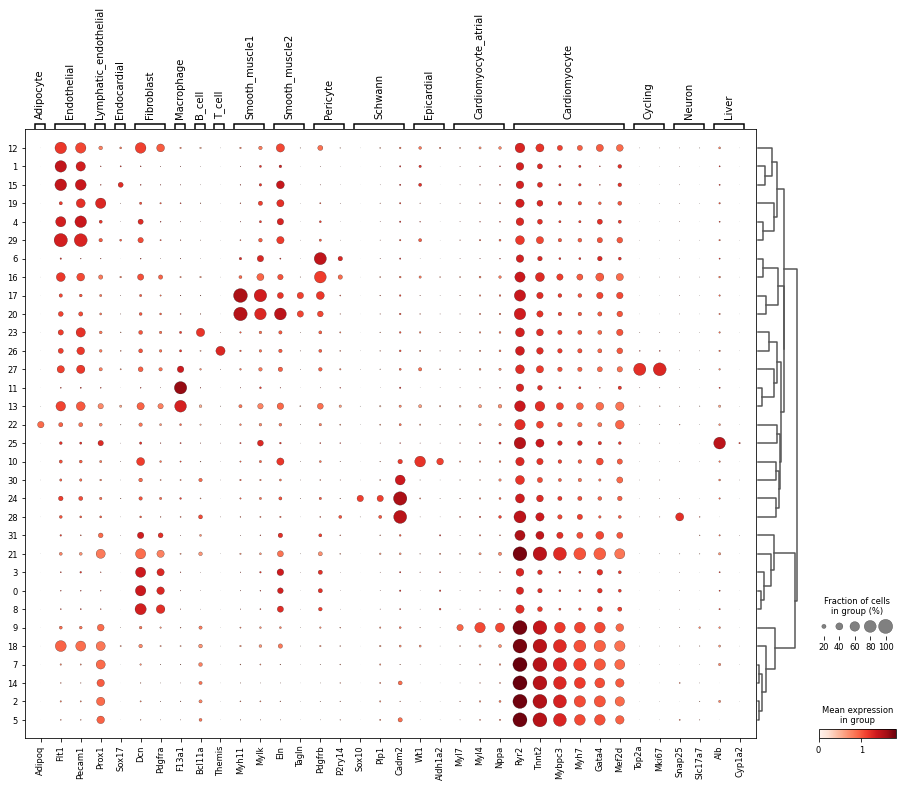

In [12]:
sc.pl.dotplot(adata, smol_marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


# Assign celltypes to clusters

In [39]:
annots = pd.read_csv("igvf_heart_annotations.csv")
annots['leiden'] = annots['leiden'].astype(str)
annotation_dict = annots.groupby('leiden').head(1).set_index('leiden')['celltype'].to_dict()


In [40]:
adata.obs['celltype'] = adata.obs['leiden'].map(annotation_dict)

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


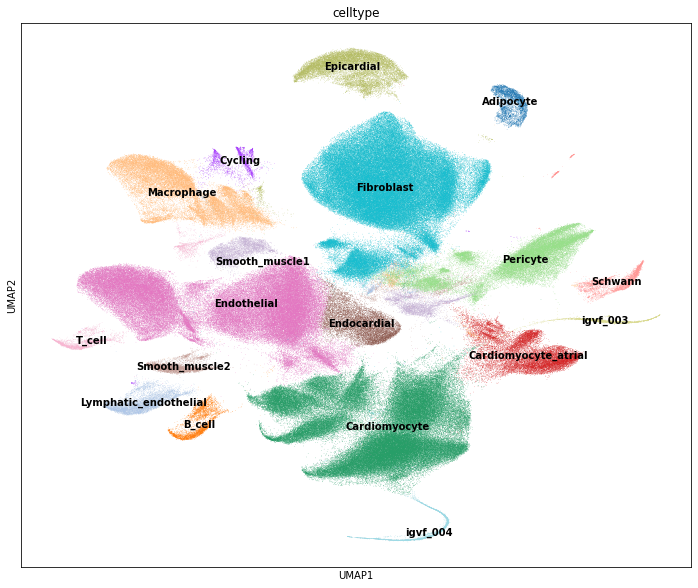

In [41]:
plt.rcParams['figure.figsize'] = (12, 10)

sc.pl.umap(adata, color=['celltype'], size=1, legend_loc = 'on data')


In [15]:
sc.tl.dendrogram(adata, groupby = 'celltype')

categories: Adipocyte, B_cell, Cardiomyocyte, etc.
var_group_labels: Adipocyte, Endothelial, Lymphatic_endothelial, etc.


/Users/liz/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


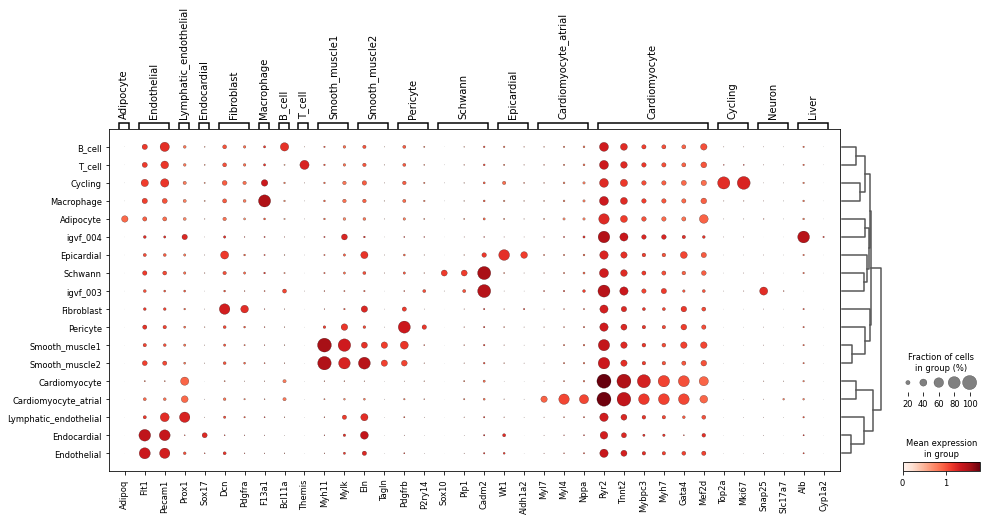

In [16]:
sc.pl.dotplot(adata, smol_marker_genes_dict, 'celltype', mean_only_expressed = True,
              dendrogram=True, log=True)


# Save annotated adata

In [42]:
adata.write_h5ad('../IGVF_analysis/annotated_tissues/Heart_annotated.h5ad')
